In [1]:
import sys
import os
import glob
from pathlib import Path
import random
import time
import datetime
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
import re
import transformers
import torch 
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
sns.set_theme(style='darkgrid')

In [2]:
from pkg.UTHBERT.preprocess_text import preprocess as my_preprocess
from pkg.UTHBERT.tokenization_mod import MecabTokenizer, FullTokenizerForMecab
from transformers import BertModel,BertConfig

In [3]:
def get_device() -> str:
    """
    Returns the best available device for PyTorch computations.
    """
    if torch.backends.mps.is_available():
        # macOS with Apple Silicon (MPS backend)
        return "mps"
    elif torch.cuda.is_available():
        # NVIDIA GPU
        return "cuda"
    else:
        # Fallback to CPU
        return "cpu"

try:
    device = torch.device(get_device())
    print(f"Using device: {device}")
except RuntimeError as e:
    print(f"Failed to initialize the device: {e}")
    device = torch.device("cpu")  # Fallback to CPU in case of an error

Using device: mps


In [4]:
seed=0
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False #Trueで高速化重視, Falseで再現性重視
seed_everything(seed)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.use_deterministic_algorithms(True)
torch.set_num_threads(1)

# Tokenizer

In [5]:
dic_path = './dic'

In [6]:
# special token for a Person's name (Do not change)
name_token = "＠＠Ｎ"

# path to the mecab-ipadic-neologd
mecab_ipadic_neologd = dic_path + '/mecab-ipadic-neologd'

# path to the J-Medic (We used MANBYO_201907_Dic-utf8.dic)
mecab_J_medic = dic_path + '/MANBYO/MANBYO_201907_Dic-utf8.dic'

# path to the uth-bert vocabulary
vocab_file = dic_path + '/UTH-BERT/bert_vocab_mc_v1_25000.txt'

In [7]:
# MecabTokenizer
sub_tokenizer = MecabTokenizer(mecab_ipadic_neologd=mecab_ipadic_neologd,
                               mecab_J_medic=mecab_J_medic,
                               name_token=name_token)

# FullTokenizerForMecab
tokenizer = FullTokenizerForMecab(sub_tokenizer=sub_tokenizer,
                                  vocab_file=vocab_file,
                                  do_lower_case=False)

In [8]:
def tokenize(sentence_list):
    token_list = []
    for s in tqdm(sentence_list):
        tokens = tokenizer.tokenize(my_preprocess(str(s)))
        ids = tokenizer.convert_tokens_to_ids(tokens)
        ids = [2] + ids + [3]
        token_list.append(ids)
    return token_list

# Data

In [9]:
def create_dataframe(folder_path):
    """
    指定されたフォルダ内のテキストファイルからDataFrameを作成する関数

    Args:
        folder_path (str): テキストファイルが入っているフォルダのパス

    Returns:
        pandas.DataFrame: 作成されたDataFrame
    """

    # フォルダ内のすべてのテキストファイルのパスを取得
    file_list = glob.glob(folder_path + "/*.txt")

    # 空のDataFrameを作成
    df_text = pd.DataFrame(columns=['id', 'text'])
    
    # label.csvを読み込む
    df_label = pd.read_csv(os.path.join(folder_path, "label.csv"))

    for file in file_list:
        # ファイル名からIDを抽出
        file_id = file.split("/")[-1].split(".")[0]
        # file_id = file.split("\\")[-1].split(".")[0] # Windows
        
        # テキストファイルを読み込む
        with open(file, 'r', encoding='utf-8') as f:
            text = f.read()

        # DataFrameに追記
        rows = []
        rows.append({'id': int(file_id), 'text': text})
        df_text = pd.concat([df_text, pd.DataFrame(rows)], ignore_index=True)
        
    # textとlabelのDataFrameを結合
    df = pd.merge(df_text, df_label, on='id', how='left')

    return df

train_folder_path = "../../radnlp_2024_train_val_20240731/ja/main_task/train"
train_df = create_dataframe(train_folder_path)
val_folder_path = "../../radnlp_2024_train_val_20240731/ja/main_task/val"
val_df = create_dataframe(val_folder_path)

In [10]:
train_df

,id,text,t,n,m
0,4166189,左肺上葉に長径 12cm の腫瘤を認めます。弓部大動脈や肺動脈浸潤が疑われます。\nT4 と...,T4,N2,M0
1,1185427,右下葉に長径 30mm 大の腫瘤を認め、肺癌を疑います。葉間胸膜の陥入を伴い、臓\n側胸膜浸...,T1c,N0,M0
2,165742,右肺尖部に長径 5 ㎝の腫瘤を認めます。辺縁に棘状影が見られ原発性肺癌を疑いま\nす。壁側胸...,T3,N0,M0
3,6848850,両側肺野に肺気腫を認めます。\n右肺下葉に分葉状腫瘤性病変を認めます（最大径 37×37×4...,T2a,N2,M1c
4,9818606,肺野背景に気腫性変化を認めます。\n右肺下葉に長径 40mm の腫瘤を認めます。分葉状の形態...,T2a,N2,M1c
...,...,...,...,...,...
103,15410359,比較可能な画像検査はありません。\n右肺尖部に長径 50mm 大の腫瘤影を認めます。病変は...,T2b,N0,M0
104,8602016,右肺門部に軟部影を認め、ご指摘の悪性腫瘍が疑われます。右下葉は無気肺となっ\nています。\n...,T2a,N3,M0
105,1876861,肺野は背景に慢性肺気腫の所見を認めます。\n右肺尖部に⻑径 48mm の不整形腫瘤を認め、原...,T2b,N2,M1b
106,13567317,背景に間質性肺炎、肺気腫を疑います。気腫合併肺線維症のような肺癌の発生しや\nすい状態を疑い...,T2b,N2,M0


In [11]:
print(train_df['t'].value_counts())
print(train_df['n'].value_counts())
print(train_df['m'].value_counts())

t
T4     31
T2a    20
T2b    19
T3     18
T1b     9
T1c     8
T0      3
Name: count, dtype: int64
n
N2    45
N0    41
N1    13
N3     9
Name: count, dtype: int64
m
M0     74
M1c    20
M1b    14
Name: count, dtype: int64


In [12]:
add_df = pd.read_csv("../add_data.csv", encoding = 'cp932')

In [13]:
add_df

,id,text,t,n,m
0,0,原発腫瘍を認めない,T0,N0,M0
1,1,上皮内癌（carcinoma in situ）：肺野型の場合は、充実成分径0cmかつ病変全体...,Tis,N0,M0
2,2,微少浸潤性腺癌：部分充実型を示し、充実成分径≦0.5cmかつ病変全体径≦3cm。かつ肺または...,T1mi,N0,M0
3,3,腫瘍の充実成分径≦1cmでかつTis・T1miには相当しない。かつ肺または臓側胸膜に覆われて...,T1a,N0,M0
4,4,腫瘍の充実成分径>1cmでかつ≦2cm。かつ肺または臓側胸膜に覆われている。かつ葉気管支より...,T1b,N0,M0
5,5,腫瘍の充実成分径>2cmでかつ≦3cm。かつ肺または臓側胸膜に覆われている。かつ葉気管支より...,T1c,N0,M0
6,6,腫瘍の充実成分径>3cmでかつ≦4cm。または充実成分径≦3cmでも以下のいずれかであるもの...,T2a,N0,M0
7,7,腫瘍の充実成分径>4cmでかつ≦5cm。または充実成分径≦3cmでも以下のいずれかであるもの...,T2b,N0,M0
8,8,充実成分径>5cmでかつ≦7cm。または充実成分径≦5cmでも以下のいずれかであるもの：壁側...,T3,N0,M0
9,9,充実成分径＞7cm、または大きさを問わず横隔膜、縦隔、心臓、大血管、気管、反回神経、食道、椎...,T4,N0,M0


In [14]:
# 訓練データを追加する
df_train = pd.concat([add_df, train_df])

In [15]:
df_train

,id,text,t,n,m
0,0,原発腫瘍を認めない,T0,N0,M0
1,1,上皮内癌（carcinoma in situ）：肺野型の場合は、充実成分径0cmかつ病変全体...,Tis,N0,M0
2,2,微少浸潤性腺癌：部分充実型を示し、充実成分径≦0.5cmかつ病変全体径≦3cm。かつ肺または...,T1mi,N0,M0
3,3,腫瘍の充実成分径≦1cmでかつTis・T1miには相当しない。かつ肺または臓側胸膜に覆われて...,T1a,N0,M0
4,4,腫瘍の充実成分径>1cmでかつ≦2cm。かつ肺または臓側胸膜に覆われている。かつ葉気管支より...,T1b,N0,M0
...,...,...,...,...,...
103,15410359,比較可能な画像検査はありません。\n右肺尖部に長径 50mm 大の腫瘤影を認めます。病変は...,T2b,N0,M0
104,8602016,右肺門部に軟部影を認め、ご指摘の悪性腫瘍が疑われます。右下葉は無気肺となっ\nています。\n...,T2a,N3,M0
105,1876861,肺野は背景に慢性肺気腫の所見を認めます。\n右肺尖部に⻑径 48mm の不整形腫瘤を認め、原...,T2b,N2,M1b
106,13567317,背景に間質性肺炎、肺気腫を疑います。気腫合併肺線維症のような肺癌の発生しや\nすい状態を疑い...,T2b,N2,M0


In [16]:
X_train, X_valid = tokenize(train_df['text'].values.tolist()), tokenize(val_df['text'].values.tolist())

  0%|          | 0/108 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [17]:
def convert_list(text_list, label_dic):
    """
    リストのテキストを、指定された辞書に基づいて数値に変換します。

    Args:
        text_list (list): 変換したいテキストのリスト
        label_dic (dict): テキストと対応する数値の辞書

    Returns:
        list: 数値に変換されたリスト
    """

    num_list = []
    for text in text_list:
        # 辞書から対応する数値を取得
        num = label_dic.get(text, None)
        if num is not None:
            num_list.append(num)
        else:
            print(f"対応する数値が見つかりません: {text}")
    return num_list

label_dic_t = {'T0':0, 'Tis':1, 'T1mi':2, 'T1a':3, 'T1b':4, 'T1c':5, 'T2a':6, 'T2b':7, 'T3':8, 'T4':9}
Yt_train, Yt_valid = convert_list(train_df['t'].values.tolist(), label_dic_t), convert_list(val_df['t'].values.tolist(), label_dic_t)

label_dic_n = {'N0':0, 'N1':1, 'N2':2, 'N3':3}
Yn_train, Yn_valid = convert_list(train_df['n'].values.tolist(), label_dic_n), convert_list(val_df['n'].values.tolist(), label_dic_n)

label_dic_m = {'M0':0, 'M1a':1, 'M1b':2, 'M1c':3}
Ym_train, Ym_valid = convert_list(train_df['m'].values.tolist(), label_dic_m), convert_list(val_df['m'].values.tolist(), label_dic_m)

# TNM各々分類モデルを学習

In [18]:
model_path = Path('./pkg/UTHBERT')
save_path = Path('./model')

In [19]:
num_classes_t=10
num_classes_n=4
num_classes_m=4

In [20]:
class MyCollator(object):
    '''
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''
    def __init__(self,test=False,percentile=100):
        self.test = test
        self.percentile = percentile
    def __call__(self, batch):
        if not self.test:
            data = [torch.tensor(item[0])  for item in batch]
            target = [item[1] for item in batch]
        else:
            data = [item for item in batch]
        
        # Padding
        data = pad_sequence(data, batch_first=True)
        data = data.clone().detach().long()
        masks = torch.where(data==0, 1, 0)
        masks = masks.clone().detach().long()
        if not self.test:
            target = torch.tensor(target, dtype=torch.long)
            return [data, masks, target]
        return [data, masks]

In [21]:
def build_data(train_data, valid_data, batch_size=8): 
        
    collate = MyCollator(percentile=100)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate) 
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate) 
     
    return train_loader, valid_loader

In [22]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)

class Net(nn.Module):
    def __init__(self, bert, num_classes):
        super(Net, self).__init__()
        self.bert = bert
        self.cls = nn.Linear(768, num_classes)

  # @torch.cuda.amp.autocast()
    def forward(self, inputs_ids, pad_masks, Attention=False):
        bout = self.bert(inputs_ids, pad_masks, output_attentions=Attention)
        bs = len(bout[0])
        h0 = [bout[0][i][0] for i in range(bs)]
        h0 = torch.stack(h0,dim=0)
        if Attention:
            return self.cls(h0),bout
        else:
            return self.cls(h0)

In [23]:
def plot_loss(train_loss, valid_loss):
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train_loss', 'valid_loss'], loc='upper right')
    plt.xticks(np.arange(0, epochs + 1, 5))
    plt.show()

In [24]:
def plot_metrics(train_acc, test_acc, test_f1):
    plt.plot(train_acc)
    plt.plot(test_acc)
    plt.plot(test_f1)
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train_acc', 'valid_acc', 'valid_F1'], loc='lower right')
    plt.xticks(np.arange(0, epochs + 1, 5))
    plt.show()

In [25]:
def macro_average_f1(label_list, pred_list):
    return f1_score(label_list, pred_list, average='macro')

In [26]:
def synchronize():
    if torch.backends.mps.is_available():
        torch.mps.synchronize()
    elif torch.cuda.is_available():
        torch.cuda.synchronize()

def run(train_loader, valid_loader, model, num_classes, epochs=10, patience=5, delta=0.0, save_path=save_path):
    
    train_loss, valid_loss, train_acc, valid_acc, valid_f1 = [], [], [], [], []
    best_f1, best_acc = 0.0, 0.0
    best_f1_epoch, best_acc_epoch = 0, 0
    best_valid_loss = np.inf
    patience_counter = 0
    
    for epoch in range(0, epochs): 
        print(f'\nEpoch {epoch + 1}/{epochs}')
        print('-' * 10)
        epoch_train_loss, epoch_valid_loss = 0.0, 0.0
        epoch_train_acc = 0.0

        model.train() 
        start = time.time()
        for data in tqdm(train_loader): 
            inputs, masks, labels = data[0].to(device), data[1].to(device), data[2].to(device)
            optimizer.zero_grad() 
            outputs = model(inputs, masks)
            loss = criterion(outputs, labels)  
            loss.backward() 
            optimizer.step() 
            epoch_train_loss += loss.item() / len(train_loader) 
            acc = (F.softmax(outputs, dim=1).argmax(dim=1) == labels).float().mean()
            epoch_train_acc += acc.item() / len(train_loader)
            del inputs, masks, labels, outputs, loss    

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        synchronize()
        elapsed_time = time.time() - start
        print(f'Train loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f}, Time: {elapsed_time:.0f}s')
        
        model.eval()
        label_li, pred_li = [], []
        with torch.no_grad():
            for data in valid_loader:
                inputs, masks, labels = data[0].to(device), data[1].to(device), data[2].to(device)
                outputs = model(inputs, masks)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item() / len(valid_loader)
                preds = F.softmax(outputs, dim=1).argmax(dim=1)
                label_li.extend(labels.cpu().numpy())
                pred_li.extend(preds.cpu().numpy())

        valid_loss.append(epoch_valid_loss)
        epoch_valid_acc = accuracy_score(label_li, pred_li)
        epoch_valid_f1 = macro_average_f1(label_li, pred_li)
        valid_acc.append(epoch_valid_acc)
        valid_f1.append(epoch_valid_f1)

        print(f'Valid loss: {epoch_valid_loss:.4f}, Valid acc: {epoch_valid_acc:.4f}, Valid F1: {epoch_valid_f1:.4f}')

        if epoch_valid_acc > best_acc: 
            best_acc = epoch_valid_acc
            best_acc_epoch = epoch
            torch.save(model.state_dict(), save_path / f'best_acc_1.pth')
        if epoch_valid_f1 > best_f1: 
            best_f1 = epoch_valid_f1
            best_f1_epoch = epoch
            torch.save(model.state_dict(), save_path / f'best_f1_1.pth')

        # # Early stopping
        # if epoch_valid_loss < best_valid_loss - delta:
        #     best_valid_loss = epoch_valid_loss
        #     patience_counter = 0  # 改善があったので、カウンタをリセット
        # else:
        #     patience_counter += 1
        # if patience_counter >= patience:
        #     print(f'Early stopping at epoch {epoch + 1}')
        #     break
            
    print('\nTraining complete')
    print(f'Best ACC: {best_acc:.4f} at epoch {best_acc_epoch}')
    print(f'Best F1: {best_f1:.4f} at epoch {best_f1_epoch}')

    return train_loss, valid_loss, train_acc, valid_acc, valid_f1 

## T分類モデル

In [27]:
batch_size=1
epochs=50
learning_rate=1e-5
momentum=0.9

In [28]:
train_data = []
valid_data = []
for x, y in zip(X_train, Yt_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Yt_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [29]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes_t).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [30]:
train_loss, valid_loss, train_acc, valid_acc, valid_f1 = run(train_loader, valid_loader, model,
                                                             num_classes_t, epochs=epochs,
                                                             save_path=save_path/'t')


Epoch 1/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 2.0241, Train acc: 0.2130, Time: 37s
Valid loss: 2.2312, Valid acc: 0.4259, Valid F1: 0.1930

Epoch 2/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.8469, Train acc: 0.2130, Time: 17s
Valid loss: 2.2491, Valid acc: 0.3333, Valid F1: 0.0625

Epoch 3/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.7638, Train acc: 0.2593, Time: 17s
Valid loss: 2.2148, Valid acc: 0.3333, Valid F1: 0.0714

Epoch 4/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.5880, Train acc: 0.4167, Time: 17s
Valid loss: 2.3049, Valid acc: 0.1667, Valid F1: 0.0357

Epoch 5/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.5476, Train acc: 0.3519, Time: 17s
Valid loss: 2.3226, Valid acc: 0.2222, Valid F1: 0.1183

Epoch 6/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.2671, Train acc: 0.5556, Time: 16s
Valid loss: 2.7521, Valid acc: 0.3333, Valid F1: 0.0702

Epoch 7/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.2727, Train acc: 0.5741, Time: 16s
Valid loss: 2.4207, Valid acc: 0.1667, Valid F1: 0.0357

Epoch 8/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.9002, Train acc: 0.2963, Time: 16s
Valid loss: 2.4842, Valid acc: 0.3333, Valid F1: 0.0776

Epoch 9/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.4086, Train acc: 0.4167, Time: 16s
Valid loss: 2.2349, Valid acc: 0.3519, Valid F1: 0.1401

Epoch 10/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.9980, Train acc: 0.6852, Time: 16s
Valid loss: 2.1930, Valid acc: 0.3333, Valid F1: 0.1010

Epoch 11/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.9745, Train acc: 0.6389, Time: 16s
Valid loss: 2.2832, Valid acc: 0.2222, Valid F1: 0.0798

Epoch 12/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.9974, Train acc: 0.6111, Time: 16s
Valid loss: 3.1373, Valid acc: 0.0556, Valid F1: 0.0370

Epoch 13/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.1712, Train acc: 0.5648, Time: 16s
Valid loss: 2.4257, Valid acc: 0.2963, Valid F1: 0.1002

Epoch 14/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.0120, Train acc: 0.6481, Time: 16s
Valid loss: 2.3350, Valid acc: 0.2963, Valid F1: 0.1517

Epoch 15/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.7168, Train acc: 0.7685, Time: 16s
Valid loss: 2.9542, Valid acc: 0.3519, Valid F1: 0.1038

Epoch 16/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.8420, Train acc: 0.7037, Time: 17s
Valid loss: 2.5154, Valid acc: 0.3333, Valid F1: 0.1531

Epoch 17/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.0171, Train acc: 0.6111, Time: 17s
Valid loss: 2.6129, Valid acc: 0.3148, Valid F1: 0.1184

Epoch 18/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.7517, Train acc: 0.7778, Time: 16s
Valid loss: 2.5476, Valid acc: 0.2593, Valid F1: 0.1060

Epoch 19/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.7981, Train acc: 0.6759, Time: 16s
Valid loss: 2.8499, Valid acc: 0.3148, Valid F1: 0.1068

Epoch 20/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.8547, Train acc: 0.6667, Time: 16s
Valid loss: 2.5232, Valid acc: 0.4074, Valid F1: 0.2276

Epoch 21/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.7857, Train acc: 0.7500, Time: 16s
Valid loss: 2.6605, Valid acc: 0.3148, Valid F1: 0.0925

Epoch 22/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.8956, Train acc: 0.6852, Time: 16s
Valid loss: 2.6957, Valid acc: 0.3148, Valid F1: 0.0850

Epoch 23/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.7162, Train acc: 0.7963, Time: 16s
Valid loss: 2.6983, Valid acc: 0.3333, Valid F1: 0.1379

Epoch 24/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6926, Train acc: 0.7407, Time: 16s
Valid loss: 2.7438, Valid acc: 0.2222, Valid F1: 0.1032

Epoch 25/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6886, Train acc: 0.7593, Time: 16s
Valid loss: 2.7620, Valid acc: 0.3148, Valid F1: 0.0885

Epoch 26/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.0305, Train acc: 0.7315, Time: 16s
Valid loss: 2.1713, Valid acc: 0.3704, Valid F1: 0.1547

Epoch 27/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.0955, Train acc: 0.6481, Time: 16s
Valid loss: 2.9208, Valid acc: 0.2037, Valid F1: 0.0960

Epoch 28/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.9535, Train acc: 0.6389, Time: 16s
Valid loss: 2.8406, Valid acc: 0.3519, Valid F1: 0.1083

Epoch 29/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.8489, Train acc: 0.7407, Time: 16s
Valid loss: 2.9356, Valid acc: 0.2407, Valid F1: 0.1050

Epoch 30/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6994, Train acc: 0.7593, Time: 16s
Valid loss: 3.4828, Valid acc: 0.2407, Valid F1: 0.1489

Epoch 31/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.8559, Train acc: 0.6481, Time: 16s
Valid loss: 3.3960, Valid acc: 0.3519, Valid F1: 0.1375

Epoch 32/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6845, Train acc: 0.7778, Time: 16s
Valid loss: 3.6332, Valid acc: 0.3148, Valid F1: 0.0921

Epoch 33/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6398, Train acc: 0.7778, Time: 16s
Valid loss: 3.9174, Valid acc: 0.1852, Valid F1: 0.0947

Epoch 34/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5920, Train acc: 0.7963, Time: 16s
Valid loss: 3.5632, Valid acc: 0.3519, Valid F1: 0.1141

Epoch 35/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5798, Train acc: 0.8148, Time: 17s
Valid loss: 3.9267, Valid acc: 0.2222, Valid F1: 0.0898

Epoch 36/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5947, Train acc: 0.7963, Time: 16s
Valid loss: 3.8625, Valid acc: 0.3148, Valid F1: 0.1375

Epoch 37/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6431, Train acc: 0.7685, Time: 16s
Valid loss: 3.3314, Valid acc: 0.2963, Valid F1: 0.1173

Epoch 38/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4587, Train acc: 0.8241, Time: 16s
Valid loss: 3.6977, Valid acc: 0.3519, Valid F1: 0.1434

Epoch 39/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5762, Train acc: 0.7778, Time: 16s
Valid loss: 3.5398, Valid acc: 0.3333, Valid F1: 0.1175

Epoch 40/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5318, Train acc: 0.8056, Time: 16s
Valid loss: 4.1131, Valid acc: 0.3519, Valid F1: 0.0922

Epoch 41/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4833, Train acc: 0.8148, Time: 16s
Valid loss: 3.7244, Valid acc: 0.3519, Valid F1: 0.1133

Epoch 42/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6093, Train acc: 0.7778, Time: 16s
Valid loss: 3.0689, Valid acc: 0.2593, Valid F1: 0.1062

Epoch 43/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4440, Train acc: 0.8333, Time: 16s
Valid loss: 3.8038, Valid acc: 0.3333, Valid F1: 0.1354

Epoch 44/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5444, Train acc: 0.7870, Time: 16s
Valid loss: 3.9149, Valid acc: 0.3148, Valid F1: 0.2270

Epoch 45/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3983, Train acc: 0.8796, Time: 16s
Valid loss: 3.7917, Valid acc: 0.2593, Valid F1: 0.1022

Epoch 46/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.7194, Train acc: 0.7315, Time: 16s
Valid loss: 2.3717, Valid acc: 0.2222, Valid F1: 0.0825

Epoch 47/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6284, Train acc: 0.7963, Time: 16s
Valid loss: 3.1151, Valid acc: 0.3333, Valid F1: 0.1006

Epoch 48/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5440, Train acc: 0.8148, Time: 16s
Valid loss: 3.1045, Valid acc: 0.2963, Valid F1: 0.1295

Epoch 49/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4626, Train acc: 0.8056, Time: 16s
Valid loss: 3.3973, Valid acc: 0.3333, Valid F1: 0.1197

Epoch 50/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2668, Train acc: 0.9167, Time: 16s
Valid loss: 3.6608, Valid acc: 0.3333, Valid F1: 0.0958

Training complete
Best ACC: 0.4259 at epoch 0
Best F1: 0.2276 at epoch 19


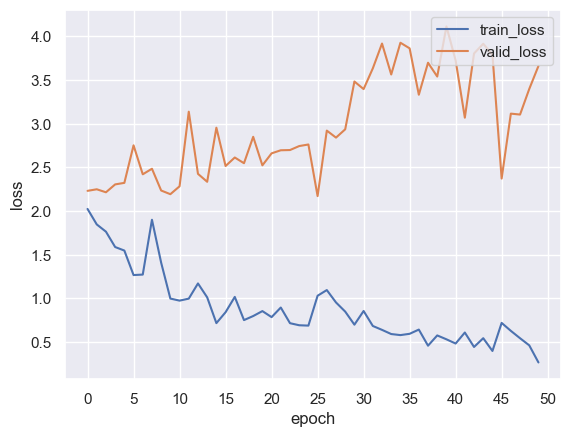

In [31]:
plot_loss(train_loss, valid_loss)

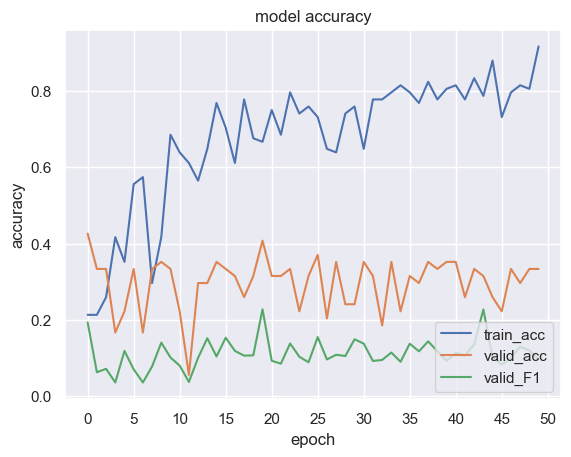

In [32]:
plot_metrics(train_acc, valid_acc, valid_f1)

In [33]:
print(f'accuracy: {max(valid_acc)}, f1 score: {max(valid_f1)}')

accuracy: 0.42592592592592593, f1 score: 0.2276203328834908


## N分類モデル

In [34]:
batch_size=1
epochs=50
learning_rate=1e-5
momentum=0.9

In [35]:
train_data = []
valid_data = []
for x, y in zip(X_train, Yn_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Yn_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [36]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes_n).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [37]:
train_loss, valid_loss, train_acc, valid_acc, valid_f1 = run(train_loader, valid_loader, model,
                                                             num_classes_n, epochs=epochs,
                                                             save_path=save_path/'n')


Epoch 1/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.2632, Train acc: 0.3889, Time: 17s
Valid loss: 1.1350, Valid acc: 0.3889, Valid F1: 0.1555

Epoch 2/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 1.1405, Train acc: 0.5093, Time: 16s
Valid loss: 1.0752, Valid acc: 0.4815, Valid F1: 0.2408

Epoch 3/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.8821, Train acc: 0.6667, Time: 17s
Valid loss: 0.6819, Valid acc: 0.7593, Valid F1: 0.4082

Epoch 4/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.8998, Train acc: 0.6481, Time: 17s
Valid loss: 1.0405, Valid acc: 0.6111, Valid F1: 0.3306

Epoch 5/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.7436, Train acc: 0.7315, Time: 17s
Valid loss: 0.6853, Valid acc: 0.7963, Valid F1: 0.4300

Epoch 6/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.8054, Train acc: 0.6944, Time: 17s
Valid loss: 0.9941, Valid acc: 0.5556, Valid F1: 0.3044

Epoch 7/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6675, Train acc: 0.7222, Time: 17s
Valid loss: 1.1740, Valid acc: 0.4815, Valid F1: 0.3462

Epoch 8/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6391, Train acc: 0.7315, Time: 18s
Valid loss: 1.4158, Valid acc: 0.4630, Valid F1: 0.3722

Epoch 9/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5189, Train acc: 0.8148, Time: 17s
Valid loss: 0.7896, Valid acc: 0.7593, Valid F1: 0.4192

Epoch 10/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.8096, Train acc: 0.6574, Time: 17s
Valid loss: 1.0057, Valid acc: 0.6296, Valid F1: 0.3417

Epoch 11/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.7007, Train acc: 0.7407, Time: 18s
Valid loss: 0.8303, Valid acc: 0.7593, Valid F1: 0.4087

Epoch 12/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5979, Train acc: 0.7870, Time: 17s
Valid loss: 0.8465, Valid acc: 0.7593, Valid F1: 0.4154

Epoch 13/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5446, Train acc: 0.8148, Time: 17s
Valid loss: 0.8137, Valid acc: 0.7778, Valid F1: 0.4179

Epoch 14/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4350, Train acc: 0.8426, Time: 17s
Valid loss: 0.7356, Valid acc: 0.7407, Valid F1: 0.4120

Epoch 15/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6167, Train acc: 0.7870, Time: 17s
Valid loss: 1.3378, Valid acc: 0.3889, Valid F1: 0.1555

Epoch 16/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4790, Train acc: 0.8241, Time: 17s
Valid loss: 0.9075, Valid acc: 0.7407, Valid F1: 0.4097

Epoch 17/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4900, Train acc: 0.8056, Time: 17s
Valid loss: 0.8724, Valid acc: 0.7407, Valid F1: 0.4173

Epoch 18/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4943, Train acc: 0.8056, Time: 17s
Valid loss: 0.8619, Valid acc: 0.6111, Valid F1: 0.4545

Epoch 19/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4666, Train acc: 0.8241, Time: 17s
Valid loss: 0.7166, Valid acc: 0.7037, Valid F1: 0.4477

Epoch 20/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4269, Train acc: 0.8704, Time: 16s
Valid loss: 0.7988, Valid acc: 0.7963, Valid F1: 0.4374

Epoch 21/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4399, Train acc: 0.8611, Time: 16s
Valid loss: 0.7783, Valid acc: 0.7407, Valid F1: 0.4128

Epoch 22/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5528, Train acc: 0.8241, Time: 17s
Valid loss: 0.7363, Valid acc: 0.7222, Valid F1: 0.4093

Epoch 23/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3484, Train acc: 0.8704, Time: 16s
Valid loss: 0.7977, Valid acc: 0.6852, Valid F1: 0.4063

Epoch 24/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5161, Train acc: 0.8333, Time: 17s
Valid loss: 0.8957, Valid acc: 0.7407, Valid F1: 0.4109

Epoch 25/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4363, Train acc: 0.8426, Time: 17s
Valid loss: 0.9622, Valid acc: 0.7037, Valid F1: 0.3928

Epoch 26/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2983, Train acc: 0.8611, Time: 17s
Valid loss: 1.0434, Valid acc: 0.8148, Valid F1: 0.4394

Epoch 27/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.7368, Train acc: 0.7500, Time: 17s
Valid loss: 0.8441, Valid acc: 0.5741, Valid F1: 0.3650

Epoch 28/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4557, Train acc: 0.8426, Time: 17s
Valid loss: 0.8157, Valid acc: 0.7593, Valid F1: 0.4145

Epoch 29/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3986, Train acc: 0.8241, Time: 17s
Valid loss: 0.7833, Valid acc: 0.7593, Valid F1: 0.4242

Epoch 30/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4074, Train acc: 0.8426, Time: 17s
Valid loss: 0.8142, Valid acc: 0.7407, Valid F1: 0.4000

Epoch 31/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4295, Train acc: 0.8611, Time: 16s
Valid loss: 0.8199, Valid acc: 0.7407, Valid F1: 0.4120

Epoch 32/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2676, Train acc: 0.9074, Time: 16s
Valid loss: 0.9626, Valid acc: 0.7222, Valid F1: 0.4034

Epoch 33/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2361, Train acc: 0.9259, Time: 16s
Valid loss: 1.1131, Valid acc: 0.6296, Valid F1: 0.4129

Epoch 34/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4845, Train acc: 0.7963, Time: 16s
Valid loss: 0.9344, Valid acc: 0.7593, Valid F1: 0.4175

Epoch 35/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2934, Train acc: 0.9074, Time: 17s
Valid loss: 1.7582, Valid acc: 0.4815, Valid F1: 0.2908

Epoch 36/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3427, Train acc: 0.8704, Time: 17s
Valid loss: 1.2855, Valid acc: 0.5185, Valid F1: 0.3466

Epoch 37/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1963, Train acc: 0.9074, Time: 16s
Valid loss: 1.0774, Valid acc: 0.7037, Valid F1: 0.4023

Epoch 38/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1861, Train acc: 0.9259, Time: 17s
Valid loss: 1.0468, Valid acc: 0.7407, Valid F1: 0.4898

Epoch 39/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2156, Train acc: 0.9167, Time: 17s
Valid loss: 1.0282, Valid acc: 0.7222, Valid F1: 0.5120

Epoch 40/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1804, Train acc: 0.9444, Time: 16s
Valid loss: 0.9702, Valid acc: 0.7407, Valid F1: 0.5626

Epoch 41/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1861, Train acc: 0.9352, Time: 16s
Valid loss: 0.8988, Valid acc: 0.7222, Valid F1: 0.4805

Epoch 42/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2041, Train acc: 0.9167, Time: 16s
Valid loss: 1.1243, Valid acc: 0.6667, Valid F1: 0.4386

Epoch 43/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2248, Train acc: 0.9444, Time: 16s
Valid loss: 0.9676, Valid acc: 0.6852, Valid F1: 0.4369

Epoch 44/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2078, Train acc: 0.9167, Time: 16s
Valid loss: 0.8971, Valid acc: 0.7222, Valid F1: 0.5136

Epoch 45/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2294, Train acc: 0.9167, Time: 16s
Valid loss: 1.7789, Valid acc: 0.5370, Valid F1: 0.3614

Epoch 46/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1356, Train acc: 0.9537, Time: 16s
Valid loss: 1.0817, Valid acc: 0.7407, Valid F1: 0.4853

Epoch 47/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3001, Train acc: 0.8981, Time: 16s
Valid loss: 2.0249, Valid acc: 0.5370, Valid F1: 0.2986

Epoch 48/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2731, Train acc: 0.8796, Time: 16s
Valid loss: 0.9295, Valid acc: 0.7037, Valid F1: 0.4063

Epoch 49/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1035, Train acc: 0.9630, Time: 16s
Valid loss: 1.0988, Valid acc: 0.7222, Valid F1: 0.4053

Epoch 50/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2906, Train acc: 0.9074, Time: 16s
Valid loss: 1.2489, Valid acc: 0.7037, Valid F1: 0.3831

Training complete
Best ACC: 0.8148 at epoch 25
Best F1: 0.5626 at epoch 39


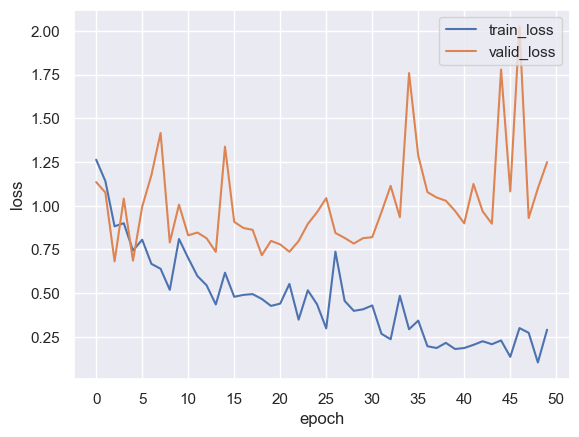

In [38]:
plot_loss(train_loss, valid_loss)

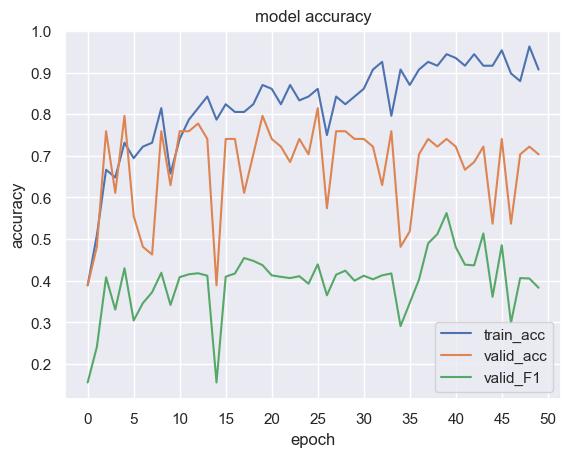

In [39]:
plot_metrics(train_acc, valid_acc, valid_f1)

In [40]:
print(f'accuracy: {max(valid_acc)}, f1 score: {max(valid_f1)}')

accuracy: 0.8148148148148148, f1 score: 0.5625621746674379


## M分類モデル

In [41]:
batch_size=1
epochs=50
learning_rate=1e-5
momentum=0.9

In [42]:
train_data = []
valid_data = []
for x, y in zip(X_train, Ym_train):
    data = [x, y]
    train_data.append(data)
for x, y in zip(X_valid, Ym_valid):
    data = [x, y]
    valid_data.append(data)
    
train_loader, valid_loader = build_data(train_data, valid_data, batch_size=batch_size)

In [43]:
config = BertConfig.from_json_file(model_path / 'bert_config.json')
bert = BertModel.from_pretrained(model_path / 'UTH_BERT.bin', config=config)
model = Net(bert, num_classes_m).to(device)

FREEZE=False
if FREEZE: 
    idx=1 #Any
    for name, param in model.named_parameters(): 
        param.requires_grad = False 
    for name, param in list(model.named_parameters())[idx:]: 
        param.requires_grad = True 
#     optimizer = optim.SGD([{'params':list(model.parameters())[idx:], 'lr':learning_rate, 'momentum':momentum}])
    optimizer = optim.Adam([{'params':list(model.parameters())[idx:], 'lr':learning_rate}]) 
    criterion = nn.CrossEntropyLoss()
else:  
#     optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

In [44]:
train_loss, valid_loss, train_acc, valid_acc, valid_f1 = run(train_loader, valid_loader, model,
                                                             num_classes_m, epochs=epochs,
                                                             save_path=save_path/'m')


Epoch 1/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.8722, Train acc: 0.6574, Time: 17s
Valid loss: 1.9469, Valid acc: 0.5000, Valid F1: 0.2222

Epoch 2/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.7641, Train acc: 0.7222, Time: 17s
Valid loss: 1.3113, Valid acc: 0.6111, Valid F1: 0.4067

Epoch 3/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5853, Train acc: 0.7500, Time: 17s
Valid loss: 1.2473, Valid acc: 0.6852, Valid F1: 0.4870

Epoch 4/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4284, Train acc: 0.8426, Time: 18s
Valid loss: 1.4903, Valid acc: 0.7222, Valid F1: 0.5228

Epoch 5/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3569, Train acc: 0.8611, Time: 17s
Valid loss: 1.5284, Valid acc: 0.7037, Valid F1: 0.3876

Epoch 6/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3848, Train acc: 0.8704, Time: 17s
Valid loss: 1.7321, Valid acc: 0.5185, Valid F1: 0.2138

Epoch 7/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2950, Train acc: 0.8981, Time: 16s
Valid loss: 1.4504, Valid acc: 0.7222, Valid F1: 0.3977

Epoch 8/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3482, Train acc: 0.8519, Time: 17s
Valid loss: 1.4021, Valid acc: 0.6852, Valid F1: 0.4004

Epoch 9/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1874, Train acc: 0.9537, Time: 17s
Valid loss: 1.6858, Valid acc: 0.5185, Valid F1: 0.2412

Epoch 10/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1879, Train acc: 0.9259, Time: 17s
Valid loss: 1.6461, Valid acc: 0.6481, Valid F1: 0.3858

Epoch 11/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1571, Train acc: 0.9630, Time: 17s
Valid loss: 2.0027, Valid acc: 0.6481, Valid F1: 0.3383

Epoch 12/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1710, Train acc: 0.9352, Time: 17s
Valid loss: 1.6133, Valid acc: 0.6667, Valid F1: 0.4037

Epoch 13/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.0263, Train acc: 1.0000, Time: 17s
Valid loss: 2.0042, Valid acc: 0.6111, Valid F1: 0.3431

Epoch 14/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.0837, Train acc: 0.9630, Time: 17s
Valid loss: 1.9315, Valid acc: 0.6667, Valid F1: 0.3817

Epoch 15/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.0616, Train acc: 0.9815, Time: 17s
Valid loss: 2.1570, Valid acc: 0.5926, Valid F1: 0.3220

Epoch 16/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.0240, Train acc: 0.9907, Time: 17s
Valid loss: 1.6804, Valid acc: 0.7222, Valid F1: 0.5245

Epoch 17/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1551, Train acc: 0.9537, Time: 17s
Valid loss: 2.2083, Valid acc: 0.5926, Valid F1: 0.3416

Epoch 18/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.0288, Train acc: 0.9907, Time: 17s
Valid loss: 2.1396, Valid acc: 0.6852, Valid F1: 0.3803

Epoch 19/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6521, Train acc: 0.7778, Time: 17s
Valid loss: 1.4807, Valid acc: 0.6296, Valid F1: 0.4383

Epoch 20/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3139, Train acc: 0.8796, Time: 17s
Valid loss: 2.5497, Valid acc: 0.5556, Valid F1: 0.3260

Epoch 21/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1379, Train acc: 0.9352, Time: 17s
Valid loss: 1.9312, Valid acc: 0.6667, Valid F1: 0.4700

Epoch 22/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4840, Train acc: 0.8519, Time: 17s
Valid loss: 2.1866, Valid acc: 0.6111, Valid F1: 0.4067

Epoch 23/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4104, Train acc: 0.8148, Time: 17s
Valid loss: 2.1731, Valid acc: 0.5185, Valid F1: 0.1972

Epoch 24/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3200, Train acc: 0.8796, Time: 17s
Valid loss: 1.6026, Valid acc: 0.7222, Valid F1: 0.5216

Epoch 25/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2338, Train acc: 0.8889, Time: 17s
Valid loss: 2.4032, Valid acc: 0.5000, Valid F1: 0.2263

Epoch 26/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.1514, Train acc: 0.9259, Time: 18s
Valid loss: 1.7235, Valid acc: 0.6667, Valid F1: 0.3964

Epoch 27/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3370, Train acc: 0.8889, Time: 18s
Valid loss: 2.6267, Valid acc: 0.5000, Valid F1: 0.1688

Epoch 28/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6874, Train acc: 0.7500, Time: 17s
Valid loss: 1.4803, Valid acc: 0.6852, Valid F1: 0.4976

Epoch 29/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3027, Train acc: 0.8889, Time: 17s
Valid loss: 1.5496, Valid acc: 0.5556, Valid F1: 0.3340

Epoch 30/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4524, Train acc: 0.7963, Time: 17s
Valid loss: 2.1692, Valid acc: 0.5370, Valid F1: 0.2945

Epoch 31/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3603, Train acc: 0.8796, Time: 17s
Valid loss: 2.4304, Valid acc: 0.5926, Valid F1: 0.2988

Epoch 32/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2620, Train acc: 0.9167, Time: 17s
Valid loss: 2.2202, Valid acc: 0.4815, Valid F1: 0.2742

Epoch 33/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5789, Train acc: 0.7407, Time: 17s
Valid loss: 1.6439, Valid acc: 0.6296, Valid F1: 0.4564

Epoch 34/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.6848, Train acc: 0.7500, Time: 17s
Valid loss: 2.3731, Valid acc: 0.5000, Valid F1: 0.2222

Epoch 35/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5677, Train acc: 0.7963, Time: 17s
Valid loss: 1.8911, Valid acc: 0.5926, Valid F1: 0.3818

Epoch 36/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3657, Train acc: 0.8241, Time: 17s
Valid loss: 2.2948, Valid acc: 0.6296, Valid F1: 0.4564

Epoch 37/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.4620, Train acc: 0.8333, Time: 17s
Valid loss: 2.2136, Valid acc: 0.6111, Valid F1: 0.3318

Epoch 38/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3393, Train acc: 0.8796, Time: 17s
Valid loss: 3.9859, Valid acc: 0.5000, Valid F1: 0.1688

Epoch 39/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.5739, Train acc: 0.7963, Time: 17s
Valid loss: 1.8920, Valid acc: 0.6111, Valid F1: 0.4067

Epoch 40/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3336, Train acc: 0.8611, Time: 17s
Valid loss: 2.2224, Valid acc: 0.6296, Valid F1: 0.3473

Epoch 41/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3064, Train acc: 0.8981, Time: 18s
Valid loss: 2.6531, Valid acc: 0.5926, Valid F1: 0.3134

Epoch 42/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3210, Train acc: 0.8611, Time: 17s
Valid loss: 2.8875, Valid acc: 0.5370, Valid F1: 0.2747

Epoch 43/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2871, Train acc: 0.8889, Time: 17s
Valid loss: 2.9730, Valid acc: 0.6481, Valid F1: 0.3383

Epoch 44/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3218, Train acc: 0.8796, Time: 17s
Valid loss: 2.9184, Valid acc: 0.5741, Valid F1: 0.2838

Epoch 45/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2720, Train acc: 0.9074, Time: 17s
Valid loss: 3.4242, Valid acc: 0.5370, Valid F1: 0.2253

Epoch 46/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.3496, Train acc: 0.8704, Time: 17s
Valid loss: 3.3445, Valid acc: 0.5185, Valid F1: 0.2063

Epoch 47/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2949, Train acc: 0.8426, Time: 17s
Valid loss: 4.5211, Valid acc: 0.5000, Valid F1: 0.2222

Epoch 48/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2885, Train acc: 0.8889, Time: 17s
Valid loss: 2.3865, Valid acc: 0.5741, Valid F1: 0.3410

Epoch 49/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.2439, Train acc: 0.8981, Time: 16s
Valid loss: 2.5504, Valid acc: 0.2778, Valid F1: 0.1913

Epoch 50/50
----------


  0%|          | 0/108 [00:00<?, ?it/s]

Train loss: 0.8913, Train acc: 0.6759, Time: 16s
Valid loss: 1.5689, Valid acc: 0.5000, Valid F1: 0.2222

Training complete
Best ACC: 0.7222 at epoch 3
Best F1: 0.5245 at epoch 15


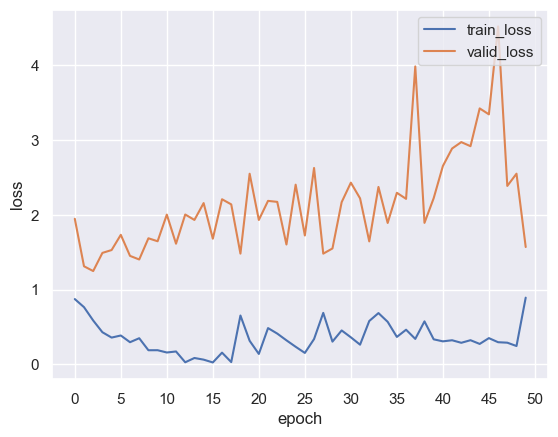

In [45]:
plot_loss(train_loss, valid_loss)

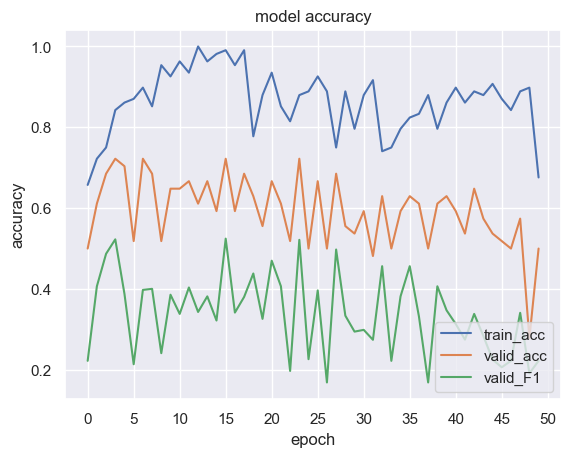

In [46]:
plot_metrics(train_acc, valid_acc, valid_f1)

In [47]:
print(f'accuracy: {max(valid_acc)}, f1 score: {max(valid_f1)}')

accuracy: 0.7222222222222222, f1 score: 0.5245304177179703
